In [2]:
# 📦 Import dependencies
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# 🔐 Load environment variables
load_dotenv()
pg_user = os.getenv("PG_USER")
pg_password = os.getenv("PG_PASSWORD")
pg_host = os.getenv("PG_HOST")
pg_db = os.getenv("PG_DB")

# 🛢️ Connect to PostgreSQL
engine = create_engine(f'postgresql://{pg_user}:{pg_password}@{pg_host}/{pg_db}')

In [4]:
# 🔍 Load raw_web_players data
query = """
SELECT 
  name,
  position,
  contract_start,
  contract_end,
  REGEXP_REPLACE(minutes_played, '[^0-9]', '', 'g')::INTEGER AS minutes_played
FROM raw.raw_web_players
WHERE minutes_played IS NOT NULL;
"""

players_df = pd.read_sql(query, engine)
players_df.head()

,name,position,contract_start,contract_end,minutes_played
0,Joško Gvardiol,Defence,2023-08,2028-06,3009
1,Erling Haaland,Offence,2022-07,2034-06,2484
2,Bernardo Silva,Midfield,2020-07,2026-06,2400
3,Mateo Kovačić,Midfield,2023-07,2027-06,2053
4,Ilkay Gündogan,Midfield,2024-08,2026-06,2052


In [12]:
query_api = """
SELECT
  m."utcDate"::date AS match_date,
  m."homeTeam.name" AS hometeam_name,
  m."awayTeam.name" AS awayteam_name,
  m."score.fullTime.home" AS home_score,
  m."score.fullTime.away" AS away_score
FROM raw.raw_api_matches m
WHERE m."homeTeam.name" = 'Manchester City FC' OR m."awayTeam.name" = 'Manchester City FC'
ORDER BY match_date;
"""


In [13]:
matches_df = pd.read_sql(query_api, engine)
matches_df.head()

,match_date,hometeam_name,awayteam_name,home_score,away_score
0,2023-08-11,Burnley FC,Manchester City FC,0,3
1,2023-08-19,Manchester City FC,Newcastle United FC,1,0
2,2023-08-27,Sheffield United FC,Manchester City FC,1,2
3,2023-09-02,Manchester City FC,Fulham FC,5,1
4,2023-09-16,West Ham United FC,Manchester City FC,1,3


In [16]:
# Convert minutes_played to integer if it's not already
players_df["minutes_played"] = pd.to_numeric(players_df["minutes_played"], errors="coerce")

# Top 10 most-used players
top_minutes = players_df.sort_values(by="minutes_played", ascending=False).head(10)
print(top_minutes)

             name    position contract_start contract_end  minutes_played
0  Joško Gvardiol     Defence        2023-08      2028-06            3009
1  Erling Haaland     Offence        2022-07      2034-06            2484
2  Bernardo Silva    Midfield        2020-07      2026-06            2400
3   Mateo Kovačić    Midfield        2023-07      2027-06            2053
4  Ilkay Gündogan    Midfield        2024-08      2026-06            2052
5         Ederson  Goalkeeper        2017-07      2026-06            2051
6      Rúben Dias     Defence        2020-09      2027-06            1998
7      Rico Lewis     Defence        2022-08      2028-06            1822
8   Manuel Akanji     Defence        2022-09      2027-06            1744
9           Sávio    Midfield        2024-07      2029-06            1742


In [17]:
# Convert match date
matches_df["match_date"] = pd.to_datetime(matches_df["match_date"])

# Filter only matches with Manchester City involved
city_matches = matches_df[
    (matches_df["hometeam_name"] == "Manchester City FC") | 
    (matches_df["awayteam_name"] == "Manchester City FC")
].copy()

# Group matches by week
city_matches["week"] = city_matches["match_date"].dt.to_period("W").apply(lambda r: r.start_time)
matches_per_week = city_matches.groupby("week").size().reset_index(name="matches")
print(matches_per_week.head())

        week  matches
0 2023-08-07        1
1 2023-08-14        1
2 2023-08-21        1
3 2023-08-28        1
4 2023-09-11        1


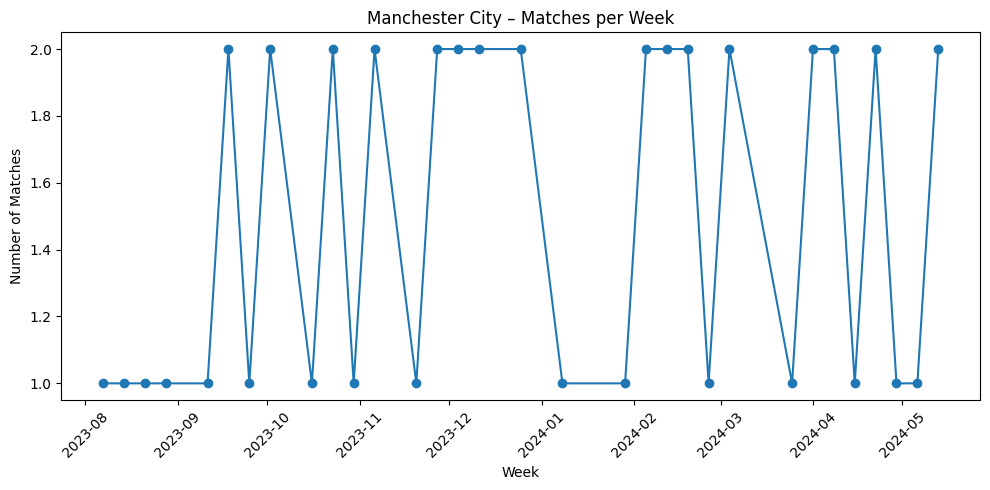

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(matches_per_week["week"], matches_per_week["matches"], marker="o")
plt.title("Manchester City – Matches per Week")
plt.xlabel("Week")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Highlight risky weeks (2+ matches)
risky_weeks = matches_per_week[matches_per_week["matches"] >= 2]
print("⚠️ High Risk Weeks:\n", risky_weeks)

⚠️ High Risk Weeks:
          week  matches
5  2023-09-18        2
7  2023-10-02        2
9  2023-10-23        2
11 2023-11-06        2
13 2023-11-27        2
14 2023-12-04        2
15 2023-12-11        2
16 2023-12-25        2
19 2024-02-05        2
20 2024-02-12        2
21 2024-02-19        2
23 2024-03-04        2
25 2024-04-01        2
26 2024-04-08        2
28 2024-04-22        2
31 2024-05-13        2


/tmp/ipykernel_49902/181336202.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


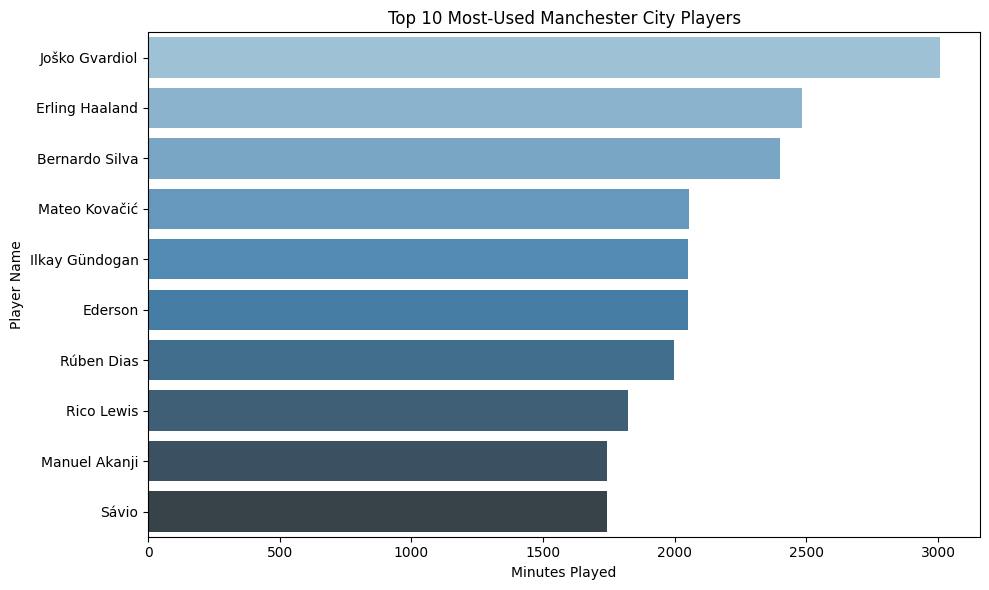

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort again just to be safe
top_minutes = players_df.sort_values(by="minutes_played", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_minutes,
    x="minutes_played",
    y="name",
    palette="Blues_d"
)
plt.title("Top 10 Most-Used Manchester City Players")
plt.xlabel("Minutes Played")
plt.ylabel("Player Name")
plt.tight_layout()
plt.show()